In [42]:
import io
import os
import platform
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

In [43]:
data=pd.read_csv('toronto.csv')
data.replace(9999,np.nan,inplace=True)
data.replace(-999,np.nan,inplace=True)
for i in range(len(data)):
    for j in range(len(data.columns)):
        if np.isnan(data.iat[i,j]):
            if i==0:
                data.iloc[i,j]=data.iat[i+1,j]
            elif i==len(data)-1:
                data.iloc[i,j]=data.iat[i-1,j]
            else:
                data.iloc[i,j]=np.nanmean([data.iat[i-1,j],data.iat[i+1,j]])

In [44]:
# data.fillna(np.mean(data),inplace=True)

In [45]:
data.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Wind Chill,NO,NO2,NOx,O3,PM25
0,-6.2,-13.2,58.0,25.0,43.0,16.1,100.68,-16.0,3.0,15.0,18.0,19.0,6.0
1,-6.0,-13.7,55.0,24.0,41.0,16.1,100.59,-16.0,2.0,14.0,16.0,19.0,7.0
2,-6.2,-13.3,57.0,24.0,45.0,16.1,100.56,-16.0,1.0,10.0,11.0,22.0,7.0
3,-6.0,-12.0,63.0,24.0,32.0,16.1,100.58,-15.0,1.0,10.0,11.0,21.0,7.0
4,-6.0,-12.2,62.0,24.0,35.0,16.1,100.50,-15.0,2.0,11.0,13.0,19.0,7.0


In [46]:
dataset=pd.DataFrame(data,columns=data.columns[:])

In [47]:
scaler = preprocessing.MinMaxScaler() 
scaled_values = scaler.fit_transform(dataset) 
dataset.loc[:,:] = scaled_values

In [48]:
data.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Wind Chill,NO,NO2,NOx,O3,PM25
0,0.340037,0.334572,0.468354,0.685714,0.605634,1.0,0.457529,0.631579,0.034091,0.245614,0.125984,0.2375,0.111111
1,0.343693,0.325279,0.430380,0.657143,0.577465,1.0,0.440154,0.631579,0.022727,0.228070,0.110236,0.2375,0.129630
2,0.340037,0.332714,0.455696,0.657143,0.633803,1.0,0.434363,0.631579,0.011364,0.157895,0.070866,0.2750,0.129630
3,0.343693,0.356877,0.531646,0.657143,0.450704,1.0,0.438224,0.657895,0.011364,0.157895,0.070866,0.2625,0.129630
4,0.343693,0.353160,0.518987,0.657143,0.492958,1.0,0.422780,0.657895,0.022727,0.175439,0.086614,0.2375,0.129630


In [49]:
data_set=np.asarray(dataset,dtype=np.float32)
seq_len=30 + 1
x=len(data_set)-seq_len
sequences = [data_set[t:t+seq_len] for t in range(x)]

In [50]:
len(sequences)

8729

In [51]:
seq=torch.FloatTensor(sequences)

In [52]:
seq.shape

torch.Size([8729, 31, 13])

In [53]:
split_row=round(0.90*seq.size(0))
x_train_set=seq[:split_row, :-1]
y_train_set=seq[:split_row, -1]
x_valid_set=seq[split_row:, :-1]
y_valid_set=seq[split_row:, -1]

In [54]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=1,dropout=0,bidirectional=False):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.dropout=dropout
        self.bidirectional=bidirectional
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, 13)
        
    def forward(self,inputs,hidden):
        outputs,hidden=self.lstm(inputs,hidden)
        predictions=self.linear(outputs[-1])
        return predictions,outputs,hidden
    
    def init_hidden(self,batch_size):
        num_directions=2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        return hidden

In [55]:
def get_batch(x,y,i,batch_size):
    if x.dim() == 2:
        x = x.unsqueeze(2)
    batch_x = x[(i*batch_size):(i*batch_size)+batch_size, :, :]
    batch_y = y[(i*batch_size):(i*batch_size)+batch_size]

    # Reshape Tensors into (seq_len, batch_size, input_size) format for the LSTM.
    batch_x = batch_x.transpose(0, 1)
    
    return batch_x, batch_y

In [56]:
def train(model,x_train_set,y_train_set,optimizer,batch_size,epoch):
    num_sequences=x_train_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.train()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_train_set, y_train_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data
        
    print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))
    return total_loss/num_batches

In [57]:
def eval(model,x_valid_set,y_valid_set,optimizer,batch_size):
    num_sequences=x_valid_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.eval()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_valid_set, y_valid_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data

    print("Validation: Loss = {:.8f}".format(total_loss/num_batches))
    return total_loss/num_batches

In [58]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

In [59]:
def load_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # load the model parameters 
    model.load_state_dict(torch.load(filename))
    
    
    return model

Training model for 30 epoch
Epoch 1: Loss = 0.02279730
Validation: Loss = 0.01521031
Epoch 2: Loss = 0.01269028
Validation: Loss = 0.01119957
Epoch 3: Loss = 0.00997352
Validation: Loss = 0.00996804
Epoch 4: Loss = 0.00943215
Validation: Loss = 0.00885922
Epoch 5: Loss = 0.00918843
Validation: Loss = 0.00805319
Epoch 6: Loss = 0.00843869
Validation: Loss = 0.00726600
Epoch 7: Loss = 0.00782921
Validation: Loss = 0.00674529
Epoch 8: Loss = 0.00762521
Validation: Loss = 0.00654204
Epoch 9: Loss = 0.00748295
Validation: Loss = 0.00638476
Epoch 10: Loss = 0.00722342
Validation: Loss = 0.00622932
Epoch 11: Loss = 0.00712044
Validation: Loss = 0.00606124
Epoch 12: Loss = 0.00688823
Validation: Loss = 0.00596424
Epoch 13: Loss = 0.00678366
Validation: Loss = 0.00581084
Epoch 14: Loss = 0.00670113
Validation: Loss = 0.00577313
Epoch 15: Loss = 0.00668432
Validation: Loss = 0.00580303
Epoch 16: Loss = 0.00665700
Validation: Loss = 0.00573532
Epoch 17: Loss = 0.00666932
Validation: Loss = 0.0056

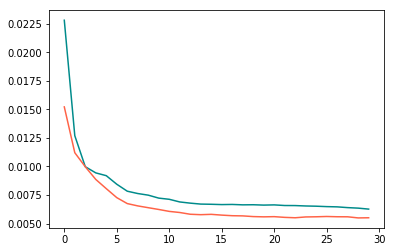

In [60]:
input_size=13
hidden_size=24
num_layers=2
lstm=LSTM(input_size,hidden_size,num_layers)

learning_rate=0.01
max_grad_norm=5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=0.000001)

batch_size = 8
num_epochs = 30 #3
# num_sequences = x_train_set.size(0)
# num_batches = num_sequences //batch_size

checkpoint_freq = 10
path = './'

train_losses=[]
valid_losses=[]

print("Training model for {} epoch".format(num_epochs))
for epoch in range(num_epochs):
#     total_loss = 0

    # Shuffle input and target sequences.
    idx = torch.randperm(x_train_set.size(0))
    x = x_train_set[idx]
    y = y_train_set[idx]
    
    train_loss=train(lstm,x_train_set,y_train_set,optimizer,batch_size,epoch)
    valid_loss=eval(lstm,x_valid_set,y_valid_set,optimizer,batch_size)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, lstm, path)
        
# Last checkpoint
save_model(num_epochs, lstm, path)
    
print("\n\n\nOptimization ended.\n")

plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(valid_losses, color="tomato",label="validation")
plt.show()

In [61]:
def predict_one_hour(model,x_valid_set,input_size,num_steps):
    predictions=torch.zeros(num_steps)
    for i, x in enumerate(x_valid_set):
        hidden=model.init_hidden(1)
        y_pred,_,_=model(x.contiguous().view(-1, 1, input_size),hidden)
        predictions[i]=y_pred[:,-1]
    return predictions

In [62]:
one_step_predictions = predict_one_hour(lstm, x_valid_set, input_size, y_valid_set.size(0))

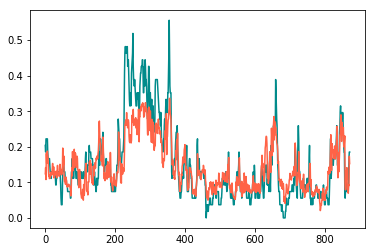

In [63]:
plt.plot(y_valid_set[:,-1].data.numpy(),color='darkcyan')
plt.plot(one_step_predictions.data.numpy(),color='tomato')
plt.show()